In [ ]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [ ]:
# make API request
endpoint = 'https://min-api.cryptocompare.com/data/v2/histohour'
res = requests.get(endpoint + '?fsym=DOGE&tsym=USD&limit=500')

# convert response to DataFrame
data = json.loads(res.content)['Data']['Data']
hist = pd.DataFrame(data)
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist = hist[['close']]
hist.columns = ['DOGE/USD']

print(hist.head(1000))

                     DOGE/USD
time                         
2023-07-07 09:00:00   0.06547
2023-07-07 10:00:00   0.06550
2023-07-07 11:00:00   0.06523
2023-07-07 12:00:00   0.06540
2023-07-07 13:00:00   0.06574
...                       ...
2023-07-28 01:00:00   0.07726
2023-07-28 02:00:00   0.07701
2023-07-28 03:00:00   0.07744
2023-07-28 04:00:00   0.07736
2023-07-28 05:00:00   0.07723

[501 rows x 1 columns]


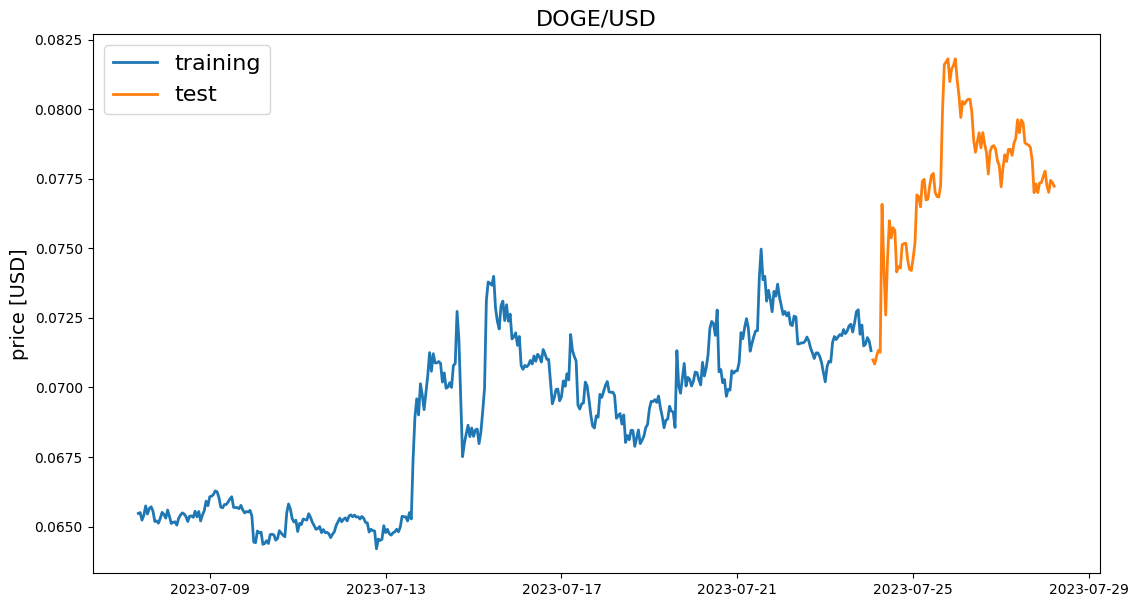

In [ ]:
# define train-test split function
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

# split data into training and test sets
train, test = train_test_split(hist, test_size=0.2)


# define plotting function
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

# plot training and test sets
line_plot(train['DOGE/USD'], test['DOGE/USD'], 'training', 'test', title='DOGE/USD')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1
def normalise_min_max(df):
  return (df - df.min()) / (data.max() - df.min())
def extract_window_data(df, window_len=5, zero_base=True):
  window_data = []
  for idx in range(len(df) - window_len):
    tmp = df[idx: (idx + window_len)].copy()
    if zero_base:
      tmp = normalise_zero_base(tmp)
      window_data.append(tmp.values)
  return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size =0.2):
  train_data, test_data = train_test_split(df, test_size=test_size)
  X_train = extract_window_data(train_data, window_len, zero_base)
  X_test = extract_window_data(test_data, window_len, zero_base)
  y_train = train_data[target_col][window_len:].values
  y_test = test_data[target_col][window_len:].values
  if zero_base:
    y_train = y_train / train_data[target_col][:-window_len].values - 1
    y_test = y_test / test_data[target_col][:-window_len].values - 1
  return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data. shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer)
  return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

# define target variable column name
target_col = 'DOGE/USD'

train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 3s 52ms/step - loss: 2.4467e-04 - val_loss: 3.9766e-04
Epoch 2/20
13/13 [==============================] - 0s 8ms/step - loss: 2.0501e-04 - val_loss: 3.2388e-04
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 1.6557e-04 - val_loss: 2.7584e-04
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 1.4599e-04 - val_loss: 2.3540e-04
Epoch 5/20
13/13 [==============================] - 0s 8ms/step - loss: 1.2771e-04 - val_loss: 2.1504e-04
Epoch 6/20
13/13 [==============================] - 0s 8ms/step - loss: 1.2153e-04 - val_loss: 2.1316e-04
Epoch 7/20
13/13 [==============================] - 0s 10ms/step - loss: 1.0637e-04 - val_loss: 2.2272e-04
Epoch 8/20
13/13 [==============================] - 0s 9ms/step - loss: 1.1145e-04 - val_loss: 2.1782e-04
Epoch 9/20
13/13 [==============================] - 0s 9ms/step - loss: 1.1161e-04 - val_loss: 1.9032e-04
Epoch 10/20
13/13 [=========================

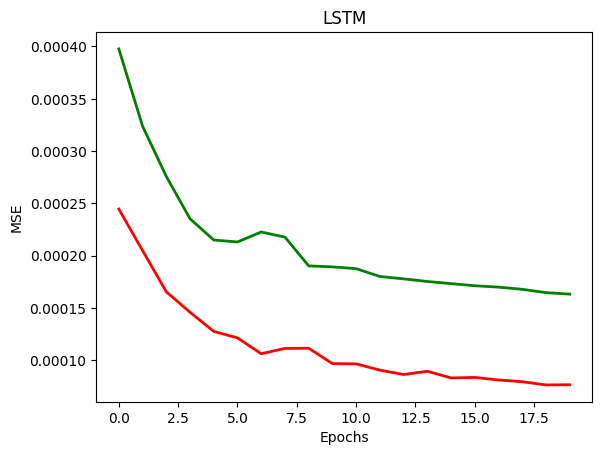

3/3 [==============================] - 0s 5ms/step


0.008005499614152159

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6599269588077521

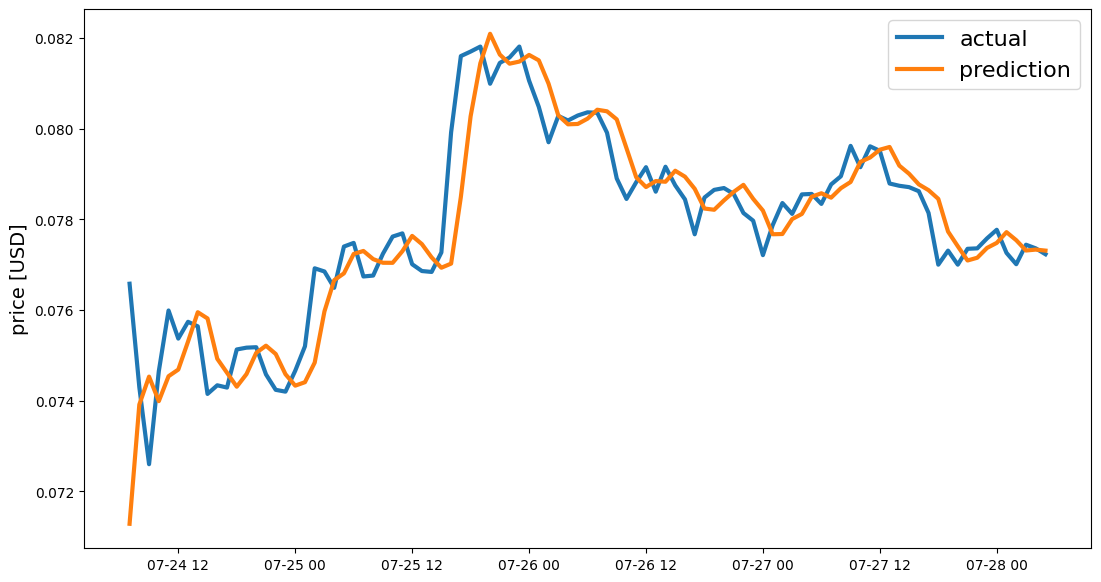

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [ ]:
def predict_and_trade(model, data, prices):
    # Predict the price changes
    changes = model.predict(data)

    # Initialize variables to track the trading position and buy/sell times
    positions = [0]
    buy_times = []
    sell_times = []

    # Loop over the price changes
    for i in range(len(changes)):
        # Compute the predicted price and the actual price
        pred_price = prices[i] + changes[i]
        actual_price = prices[i + 1]

        # If the predicted price is higher than the actual price, buy
        if pred_price > actual_price:
            positions.append(1)
            buy_times.append(prices.index[i + 1])
        # Otherwise, sell
        else:
            positions.append(0)
            sell_times.append(prices.index[i + 1])

    # Return the trading positions and buy/sell times
    return positions, buy_times, sell_times


In [ ]:
import pandas as pd
import numpy as np

def sma_crossover_strategy(df, short_window=50, long_window=200):
    # Calculate the short and long SMAs
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()

    # Generate buy and sell signals
    df['Signal'] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
    df['Signal_shifted'] = df['Signal'].shift(1)
    df['Buy'] = np.where((df['Signal'] > df['Signal_shifted']) & (df['Signal'] > 0), df['Close'], np.nan)
    df['Sell'] = np.where((df['Signal'] < df['Signal_shifted']) & (df['Signal'] < 0), df['Close'], np.nan)

    # Set initial position to zero
    df['Position'] = 0

    # Fill in positions for buy and sell signals
    df.loc[df['Buy'].notnull(), 'Position'] = 1
    df.loc[df['Sell'].notnull(), 'Position'] = -1

    # Forward fill positions to simulate holding
    df['Position'].ffill(inplace=True)

    return df


In [ ]:
import requests
import pandas as pd
import numpy as np

url = 'https://min-api.cryptocompare.com/data/histoday?fsym=DOGE&tsym=CAD&limit=500'
response = requests.get(url)

if response.status_code == 200:
    data = response.json()['Data']
    df = pd.DataFrame.from_dict(data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    df.index.name = None
    target_col = 'close'
    df.drop(["conversionType", "conversionSymbol"], axis='columns', inplace=True)

    # Define moving average crossover strategy
    short_window = 50
    long_window = 200
    df['short_ma'] = df[target_col].rolling(window=short_window).mean()
    df['long_ma'] = df[target_col].rolling(window=long_window).mean()

    # Calculate signals based on moving average crossover
    df['signal'] = 0.0
    df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1.0, 0.0)

    # Calculate positions based on signals
    df['positions'] = df['signal'].diff()

    # Backtest strategy and calculate profit/loss
    initial_capital = 50.0
    positions = pd.Series(index=df.index, data=0.0)
    positions.iloc[0] = 0.0
    positions.iloc[1:] = np.sign(df['positions'].values[:-1])
    portfolio = positions * df[target_col]
    pos_diff = positions.diff()
    portfolio.iloc[0] = initial_capital
    portfolio.iloc[0] -= abs(pos_diff.iloc[0]) * df[target_col].iloc[0]
    portfolio = portfolio.cumsum()
    returns = portfolio.pct_change()
    print(f'Total profit/loss: {portfolio.iloc[-1] - initial_capital:.2f}')


Total profit/loss: -49.98


In [ ]:
import requests
import pandas as pd
import numpy as np

# Set the API endpoint and parameters
url = 'https://min-api.cryptocompare.com/data/histoday'
params = {'fsym': 'DOGE', 'tsym': 'CAD', 'limit': 500}

# Make the API request and parse the response
response = requests.get(url, params=params)
data = response.json()['Data']

# Convert the data to a DataFrame
df = pd.DataFrame.from_dict(data)

# Convert the timestamp to a datetime object and set it as the index
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# Apply the trading strategy
target_col = 'close'
short_window = 50
long_window = 200
df['short_ma'] = df[target_col].rolling(window=short_window).mean()
df['long_ma'] = df[target_col].rolling(window=long_window).mean()
df['signal'] = 0.0
df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1.0, 0.0)
df['positions'] = df['signal'].diff()
initial_capital = 50.0
positions = pd.Series(index=df.index, data=0.0)
positions.iloc[0] = 0.0
positions.iloc[1:] = np.sign(df['positions'].values[:-1])
portfolio = positions * df[target_col]
pos_diff = positions.diff()
portfolio.iloc[0] = initial_capital
portfolio.iloc[0] -= abs(pos_diff.iloc[0]) * df[target_col].iloc[0]
portfolio = portfolio.cumsum()
returns = portfolio.pct_change()

# Print the buy and sell signals with Timestamp
df['Buy'] = np.where(df['positions'] == 1, df[target_col], np.nan)
df['Sell'] = np.where(df['positions'] == -1, df[target_col], np.nan)
print(df.loc[df['Buy'].notnull() | df['Sell'].notnull(), ['Buy', 'Sell']].reset_index())

# Print total profit/loss
print(f'Total profit/loss: {portfolio.iloc[-1] - initial_capital:.2f}')


        time     Buy  Sell
0 2022-11-07  0.1501   NaN
1 2023-03-27     NaN   0.1
Total profit/loss: -49.98


<ipython-input-14-35ccd98500ac>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1.0, 0.0)


<ipython-input-15-b99a3ac09d5b>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1.0, 0.0)


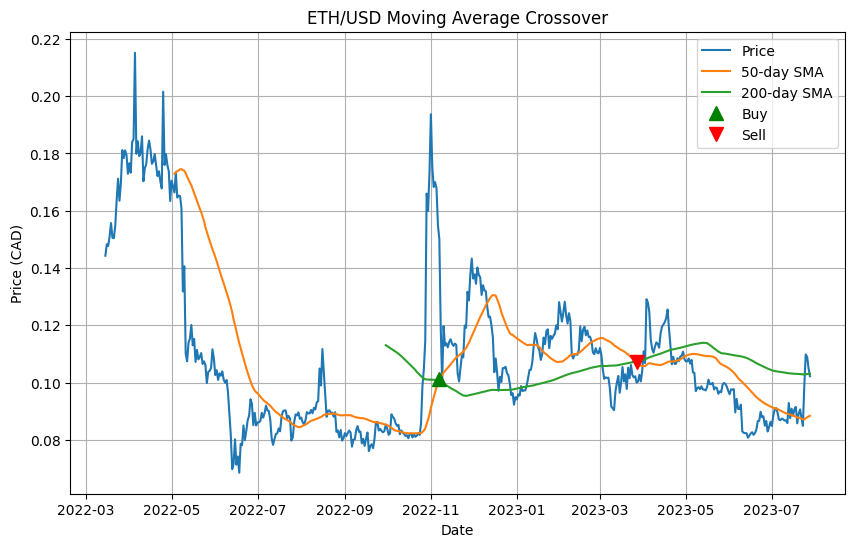

            positions
time                 
2022-03-15        NaN
2022-11-07        1.0
2023-03-27       -1.0


In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the API endpoint and parameters
url = 'https://min-api.cryptocompare.com/data/histoday'
params = {'fsym': 'DOGE', 'tsym': 'CAD', 'limit': 500}

# Make the API request and parse the response
response = requests.get(url, params=params)
data = response.json()['Data']

# Convert the data to a DataFrame
df = pd.DataFrame.from_dict(data)

# Convert the timestamp to a datetime object and set it as the index
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# Define moving average crossover strategy
short_window = 50
long_window = 200
target_col = 'close'
df['short_ma'] = df[target_col].rolling(window=short_window).mean()
df['long_ma'] = df[target_col].rolling(window=long_window).mean()

# Calculate signals based on moving average crossover
df['signal'] = 0.0
df['signal'][short_window:] = np.where(df['short_ma'][short_window:] > df['long_ma'][short_window:], 1.0, 0.0)

# Calculate positions based on signals
df['positions'] = df['signal'].diff()

# Backtest strategy and calculate profit/loss
initial_capital = 1000.0
positions = pd.Series(index=df.index, data=0.0)
positions.iloc[0] = 0.0
positions.iloc[1:] = np.sign(df['positions'].values[:-1])
portfolio = positions * df[target_col]
pos_diff = positions.diff()
portfolio.iloc[0] = initial_capital
portfolio.iloc[0] -= abs(pos_diff.iloc[0]) * df[target_col].iloc[0]
portfolio = portfolio.cumsum()
returns = portfolio.pct_change()

# Plot the price and moving averages
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.index, df[target_col], label='Price')
ax.plot(df.index, df['short_ma'], label=f'{short_window}-day SMA')
ax.plot(df.index, df['long_ma'], label=f'{long_window}-day SMA')

# Plot the buy and sell signals
ax.plot(df.loc[df['positions'] == 1.0].index,
        df['short_ma'][df['positions'] == 1.0],
        '^', markersize=10, color='g', label='Buy')
ax.plot(df.loc[df['positions'] == -1.0].index,
        df['short_ma'][df['positions'] == -1.0],
        'v', markersize=10, color='r', label='Sell')

# Set the chart parameters
ax.set(title='ETH/USD Moving Average Crossover',
       ylabel='Price (CAD)',
       xlabel='Date')
ax.legend()
ax.grid()

# Show the plot
plt.show()

# Print the buy and sell signals with Timestamp
print(df.loc[df['positions'] != 0.0, ['positions']])
